# SSVEP: Offline processing using Machine Leaning Method

## Step 0: Import neceessary toolboxes

In [263]:
# import require library for preprocess
import mne
import numpy as np
from mne.channels import make_standard_montage
import matplotlib.pyplot as plt
from mne.datasets import eegbci
import scipy
import pickle
import seaborn as sns

# import require library for classification
from sklearn.svm import SVC # SVM library
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA library
from sklearn.neighbors import KNeighborsClassifier # KNN library
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn.metrics import classification_report,confusion_matrix # Result representation
SEED = 42

## Step 1: Read data file

In [264]:
# read biosemi file (bdf)
raw1 = mne.io.read_raw_bdf("C:\\Users\\pipo_\\OneDrive\\Desktop\\neuromedia\\group1_block1.bdf", preload=True, verbose=False) 
raw2 = mne.io.read_raw_bdf("C:\\Users\\pipo_\\OneDrive\\Desktop\\neuromedia\\group1_block2.bdf", preload=True, verbose=False) 
raw3 = mne.io.read_raw_bdf("C:\\Users\\pipo_\\OneDrive\\Desktop\\neuromedia\\group1_block3.bdf", preload=True, verbose=False) 
raw4 = mne.io.read_raw_bdf("C:\\Users\\pipo_\\OneDrive\\Desktop\\neuromedia\\group1_block4.bdf", preload=True, verbose=False) 
raw = mne.concatenate_raws([raw1, raw2, raw3, raw4])

eegbci.standardize(raw)

## Step 2: Data preprocessing -- set channel locations/ downsampling/ frequency filtering (bandpass)/ epoching

In [ ]:
from scipy.signal import filtfilt
from scipy import signal

# Set channel location
montage = make_standard_montage("biosemi64")
raw.set_montage(montage, on_missing='ignore')
sampling_rate = raw.info['sfreq']

#Step 1 resample
raw = raw.resample(128, verbose = False)

#Step 2 reference
raw = raw.set_eeg_reference('average')  

#Step 2 
raw = raw.copy().notch_filter(freqs=50)
raw = raw.copy().filter(l_freq=1, h_freq=40, verbose = False)

# Get events and timestamps
events = mne.find_events(raw, shortest_event = 0, verbose = False) 

# Create event dictionary 
event_dict =  {'12Hz': 8,
'24Hz': 4,
'6Hz': 10,
'30Hz': 2
}

# Use events and event dictionary to cut data into Epochs
ssvep_chans = ['O1','Oz','O2'] 

epoch_cut_time = 4
Epochs = mne.Epochs(raw, events, 
    tmin= -1.0,  
    tmax= 5.0,    
    event_id=event_dict,
    picks = ssvep_chans,
    preload = True,
    event_repeated='drop',
    baseline= (-1,0),
    verbose=False
)

Epochs = Epochs.copy().crop(tmin = 0.0, tmax = epoch_cut_time)
train_label = Epochs['12Hz','6Hz', '24Hz', '30Hz'].events[:,-1]
Epochs_data = Epochs.get_data()

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 4 contiguous segments
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


## Step3: Feature extraction

## 3.1 Fast Fourier Transform

In [267]:
# Compute FFT for each epoch and return the power spectral density
def compute_fft(epoch_data, sampling_rate, time_length):
    num_epochs, num_channels, num_timepoints = epoch_data.shape
    freqs = np.fft.fftfreq(num_timepoints-1, 1 / sampling_rate)
    fft_data = np.zeros((num_epochs, num_channels, len(freqs)+1))

    # Compute FFT for each channel and each epoch
    for epoch_idx in range(num_epochs):
        for ch_idx in range(num_channels):     
            fft_result = scipy.fft.fft(epoch_data[epoch_idx, ch_idx, 0:int(sampling_rate*time_length)])
            power_spectrum = np.abs(fft_result) ** 2  # Power = |FFT|^2
            fft_data[epoch_idx, ch_idx, :] = power_spectrum

    return fft_data, freqs

# Example usage
fft_out, freqs_out = compute_fft(Epochs_data, sampling_rate, epoch_cut_time)
print(fft_out.shape)

fft_train = np.stack([arr.flatten() for arr in fft_out])
print(fft_train.shape)


(192, 3, 513)
(192, 1539)


## 3.2 Power Spectrum Density

In [268]:
psd_epoch = Epochs['12Hz','6Hz', '24Hz', '30Hz'].pick(ssvep_chans).compute_psd(fmin=2.0, fmax=40.0)
print(psd_epoch.shape)

psd_train = np.stack([arr.flatten() for arr in psd_epoch])
print(psd_train.shape)

    Using multitaper spectrum estimation with 7 DPSS windows
(192, 3, 152)
(192, 456)


    Using multitaper spectrum estimation with 7 DPSS windows


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...


c:\git\BCI-Class-Material\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


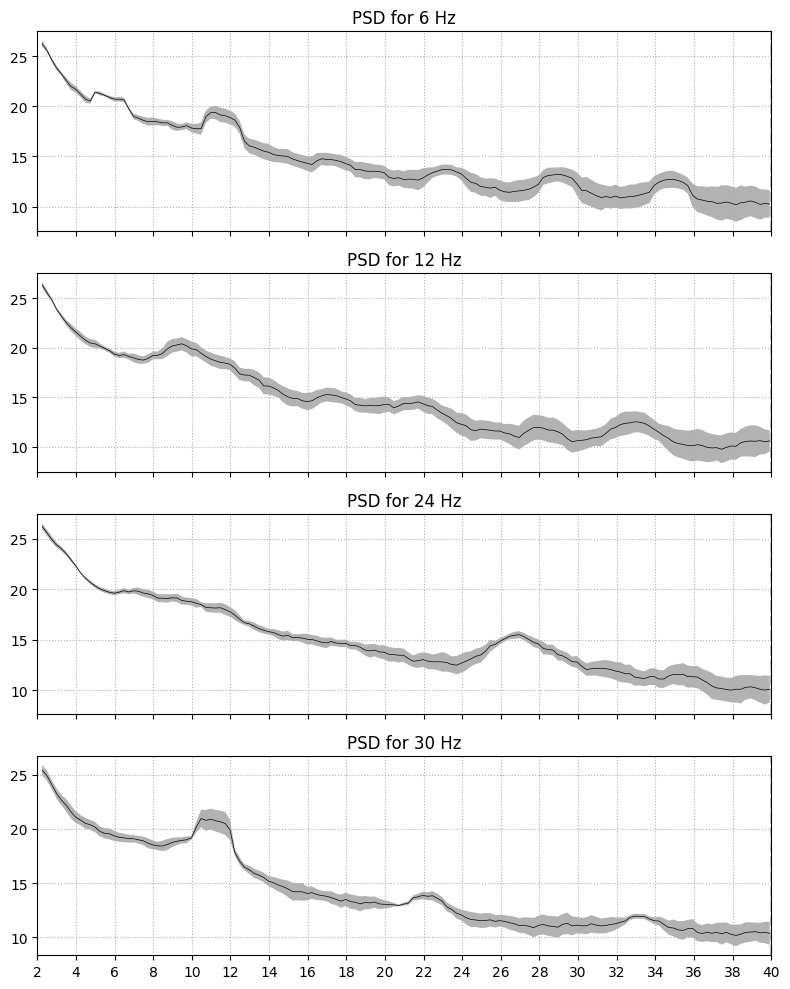

In [269]:
# Compute the PSD for different frequency epochs
psd_6Hz = Epochs['6Hz'].pick(ssvep_chans).compute_psd(fmin=2.0, fmax=40.0)
psd_12Hz = Epochs['12Hz'].pick(ssvep_chans).compute_psd(fmin=2.0, fmax=40.0)
psd_24Hz = Epochs['24Hz'].pick(ssvep_chans).compute_psd(fmin=2.0, fmax=40.0)
psd_30Hz = Epochs['30Hz'].pick(ssvep_chans).compute_psd(fmin=2.0, fmax=40.0)

# Store PSD objects and titles
psd_data = [(psd_6Hz, '6 Hz'), (psd_12Hz, '12 Hz'), (psd_24Hz, '24 Hz'), (psd_30Hz, '30 Hz')]

# Create subplots (1 column, 4 rows)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 10), sharex=True)

# Plot each PSD computation in a separate subplot
for ax, (psd, title) in zip(axes, psd_data):
    psd.plot(average=True, amplitude=False, picks="data", exclude="bads", axes=ax)
    ax.set_title(f'PSD for {title}')
    ax.set_xticks(np.arange(2, 41, 2))  # Set x-axis ticks from 2 to 60 Hz
    ax.set_xticklabels(np.arange(2, 41, 2))  # Set x-axis labels

plt.tight_layout()
plt.show()

## Step4: Classification

In [270]:
x_train, x_test, y_train, y_test = train_test_split(psd_train, train_label, test_size=0.3, random_state=SEED, stratify=train_label)

### Apply Scaler

from sklearn.preprocessing import RobustScaler, StandardScaler

scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


## 4.1 LDA

In [271]:
def GetConfusionMatrix(models, X_train, X_test, y_train, y_test, target_names):
    y_pred = models.predict(X_train)
    print("Classification TRAIN DATA \n=======================")
    print(classification_report(y_true= y_train, y_pred=y_pred, target_names= target_names))
    print("Confusion matrix \n=======================")
    print(confusion_matrix(y_true= y_train, y_pred=y_pred))

    y_pred = models.predict(X_test)
    print("Classification TEST DATA \n=======================")
    print(classification_report(y_true=y_test, y_pred=y_pred, target_names= target_names))
    print("Confusion matrix \n=======================")
    print(confusion_matrix(y_true=y_test, y_pred=y_pred))

    

In [272]:
lda = LinearDiscriminantAnalysis()

param_grid = {'solver': ['svd']}

cv_splitter = KFold(n_splits=5, shuffle=True, random_state=SEED)
tuned_clf_lda = GridSearchCV(estimator=lda, param_grid=param_grid,
                    scoring='accuracy', refit='accuracy', cv=cv_splitter)

tuned_clf_lda.fit(x_train, y_train)
print(f"Best parameters: {tuned_clf_lda.best_params_}")
print(f"Best cross-validation score: {tuned_clf_lda.best_score_:.3f}")
label_names = ['12Hz', '6Hz', '24Hz', '30Hz']

GetConfusionMatrix(tuned_clf_lda, x_train, x_test, y_train, y_test, label_names)

Best parameters: {'solver': 'svd'}
Best cross-validation score: 0.799
Classification TRAIN DATA 
              precision    recall  f1-score   support

        12Hz       1.00      1.00      1.00        33
         6Hz       1.00      1.00      1.00        34
        24Hz       1.00      1.00      1.00        33
        30Hz       1.00      1.00      1.00        34

    accuracy                           1.00       134
   macro avg       1.00      1.00      1.00       134
weighted avg       1.00      1.00      1.00       134

Confusion matrix 
[[33  0  0  0]
 [ 0 34  0  0]
 [ 0  0 33  0]
 [ 0  0  0 34]]
Classification TEST DATA 
              precision    recall  f1-score   support

        12Hz       0.76      0.87      0.81        15
         6Hz       0.92      0.79      0.85        14
        24Hz       0.57      0.53      0.55        15
        30Hz       0.80      0.86      0.83        14

    accuracy                           0.76        58
   macro avg       0.76      0.76    

## 4.2 SVM

In [273]:
param_grid = {'C':  [0.1, 1, 10, 100], 'kernel': ['rbf', 'poly']}

svm_model =  SVC(random_state=SEED)
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=SEED)
tuned_clf_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid,
                    scoring='accuracy', refit='accuracy', cv=cv_splitter)

tuned_clf_svm.fit(x_train, y_train)

print(f"Best parameters: {tuned_clf_svm.best_params_}")
print(f"Best cross-validation score: {tuned_clf_svm.best_score_:.3f}")
label_names = ['12Hz', '6Hz', '24Hz', '30Hz']


GetConfusionMatrix(tuned_clf_svm, x_train, x_test, y_train, y_test, label_names)

Best parameters: {'C': 10, 'kernel': 'rbf'}
Best cross-validation score: 0.873
Classification TRAIN DATA 
              precision    recall  f1-score   support

        12Hz       1.00      1.00      1.00        33
         6Hz       1.00      1.00      1.00        34
        24Hz       1.00      1.00      1.00        33
        30Hz       1.00      1.00      1.00        34

    accuracy                           1.00       134
   macro avg       1.00      1.00      1.00       134
weighted avg       1.00      1.00      1.00       134

Confusion matrix 
[[33  0  0  0]
 [ 0 34  0  0]
 [ 0  0 33  0]
 [ 0  0  0 34]]
Classification TEST DATA 
              precision    recall  f1-score   support

        12Hz       0.92      0.73      0.81        15
         6Hz       0.93      0.93      0.93        14
        24Hz       0.72      0.87      0.79        15
        30Hz       0.79      0.79      0.79        14

    accuracy                           0.83        58
   macro avg       0.84     

## 4.3 KNN

In [274]:
knn = KNeighborsClassifier(n_neighbors= 10, weights = "uniform")

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}


cv_splitter = KFold(n_splits=5, shuffle=True, random_state=SEED)
tuned_clf_knn = GridSearchCV(estimator=knn, param_grid=param_grid,
                    scoring='accuracy', refit='accuracy', cv=cv_splitter)

tuned_clf_knn.fit(x_train, y_train)

print(f"Best parameters: {tuned_clf_knn.best_params_}")
print(f"Best cross-validation score: {tuned_clf_knn.best_score_:.3f}")

label_names = ['12Hz', '6Hz', '24Hz', '30Hz']

GetConfusionMatrix(tuned_clf_knn, x_train, x_test, y_train, y_test, label_names)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.746
Classification TRAIN DATA 
              precision    recall  f1-score   support

        12Hz       1.00      1.00      1.00        33
         6Hz       1.00      1.00      1.00        34
        24Hz       1.00      1.00      1.00        33
        30Hz       1.00      1.00      1.00        34

    accuracy                           1.00       134
   macro avg       1.00      1.00      1.00       134
weighted avg       1.00      1.00      1.00       134

Confusion matrix 
[[33  0  0  0]
 [ 0 34  0  0]
 [ 0  0 33  0]
 [ 0  0  0 34]]
Classification TEST DATA 
              precision    recall  f1-score   support

        12Hz       0.62      0.87      0.72        15
         6Hz       0.92      0.86      0.89        14
        24Hz       0.67      0.53      0.59        15
        30Hz       0.75      0.64      0.69        14

    accuracy                           0.72 